![title](http://opencv-python-tutroals.readthedocs.io/en/latest/_images/kmeansicon.jpg)

In this notebook we'll finally have a glimpse at unsupervised learning. Specifically, we are going to look at **clustering**. Remember that the basis of supervised learning is that we have a target prediction variable that our model is trying to...predict. But, if we remove that target prediction variable, all we have are a series of data points representing some entity. However, if we look at the similarities between these data points, we may find that some are more akin to others. Thus, we can make our own "classification" based on these similarities. Let's try seeing this in action.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pokemon = pd.read_csv("Pokemon.csv", index_col = "#")
pokemon.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Now that we have our dataset loaded, let's create a subset of the dataset with only the stats of the Pokemon. 

In [10]:
stats = pokemon[pokemon.columns[4:10]]
features = list(stats.columns)
stats.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
#,,,,,,
1,45,49,49,65,65,45
2,60,62,63,80,80,60
3,80,82,83,100,100,80
3,80,100,123,122,120,80
4,39,52,43,60,50,65


Now that we have our data ready, let's take a look at the **K-Means** clustering algorithm.

## K-Means

The K-Means algorithm takes a dataset of N data points, which will be divided into K centers, which will be the base of each cluster. All data points are there classified based on their data and assigned near a center. The algorithm then outputs K clusters, where each point inside the cluster is closer to its center than to any other center.

The mathematical condition for the $K$ clusters $C_k$ and the $K$ centers $\mu_k$ can be expressed as:

Minimize: ![title](https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+%5Csum_%7Bk%3D1%7D%5EK+%5Csum_%7B%5Cmathrm%7Bx%7D_n+%5Cin+C_k%7D+%7C%7C%5Cmathrm%7Bx%7D_n+-+%5Cmu_k+%7C%7C%5E2&bg=ffffff&fg=000000&s=1)

With respect to $C_k$ and $\mu_k$. This means that the distance to each point from its cluster center is minimized. One solution to this problem is **Lloyd's algorithm**, which converges the nearest minimum it can find. The procedure goes like this:

 1- Once a set of centers $\mu_k$ is available, the clusters are updated to contain the points closest in distance to each    center. 
 
![title](https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+C_k+%3D+%5C%7B%5Cmathrm%7Bx%7D_n+%3A+%7C%7C%5Cmathrm%7Bx%7D_n+-+%5Cmu_k%7C%7C+%5Cleq+%5Cmathrm%7B%5C%2C%5C%2Call%5C%2C%5C%2C%7D+%7C%7C%5Cmathrm%7Bx%7D_n+-+%5Cmu_l%7C%7C%5C%7D%5Cqquad%281%29&bg=ffffff&fg=000000&s=1)

2- Given a set of clusters, the centers are recalculated as the means of all points belonging to a cluster.

![title](https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+%5Cmu_k+%3D+%5Cfrac%7B1%7D%7BC_k%7D%5Csum_%7B%5Cmathrm%7Bx%7D_n+%5Cin+C_k%7D%5Cmathrm%7Bx%7D_n%5Cqquad%282%29&bg=ffffff&fg=000000&s=1) 

In other words, as more data points are being added, the clusters are updated based on the distance each point has to the center of its cluster, and the centers are updated based on the mean of all points of their cluster. This means that both cluster centers and cluster points are updated along the way. This procedure is repeated until assignments no longer change, and we converge at a local minimum. 

Let's now implement Lloyd's Algorithm.

First, let's create a function that creates or cluster data. This will take the data and the centers and assign each point to the best center it can find. It then returns a dictionary of centers and their respective points.

In [2]:
def cluster_data(data, center):
    clusters = {}
    for point in data:
        bestcenter = min([(i[0],np.linalg.norm(point - center[i[0]])) for i in enumerate(center)],
                         key = lambda t:t[1])[0]
        try:
            clusters[bestcenter].append(point)
        except:
            clusters[bestcenter] = [point]
    return clusters

The next step is to recreate the cluster centers on each step based on the means of the cluster data points.

In [3]:
def recreate_centers(center,clusters):
    new_center = []
    keys = sorted(clusters.keys())
    for key in keys:
        #Row based mean.
        new_center.append(np.mean(clusters[key], axis = 0))
    return new_center

We also need to check if the algorithm has converged already. This happens when there is no change between the old and new centers.

In [4]:
def Converged(new_center,center):
    new_points = set([tuple(point) for point in new_center])
    old_points = set([tuple(point) for point in center])
    return new_points == old_points

Finally, we round it all together into one function.

In [5]:
import random
def K_Means(data,K):
    random.seed(0)
    oldcenter = random.sample(data, K)
    newcenter = random.sample(data, K)
    clusters = None
    while not Converged(newcenter,oldcenter):
        oldcenter = newcenter
        clusters = cluster_data(data,newcenter)
        center = recreate_centers(oldcenter,clusters)
    return (newcenter,clusters)

Now, let's try to cluster our pokemon data.

In [6]:
np.random.seed(0)
def Create_KCluster(values,K):
    
    KCluster = K_Means(values,K)
    
    print(KCluster[0])
    Cluster_dict = {}
    #Create 2D points of the mean and the standard deviation in order to plot it.
    #Some tips to be able to plot clusters in the 2D space would be helpful, it's the stuff of nightmares for me.
    for i in range(len(KCluster[0])):
        KCluster[1][i] = [(stat.mean(),stat.std()) for stat in KCluster[1][i]]
        Cluster_dict[(KCluster[0][i].mean(),KCluster[0][i].std())] = KCluster[1][i]


    print(Cluster_dict.keys())
    stat_df = pd.DataFrame({
        "Center": list(Cluster_dict.keys()),
        "Points": list(Cluster_dict.values())
    })
    return stat_df


In [7]:
from matplotlib import rcParams 
#Our usual Parameter function.
def MatplotLib_Params():
    #The size of the figure.
    rcParams['figure.figsize'] = (8, 6)
    #Dots per inch or resolution of the figure.
    rcParams['figure.dpi'] = 150
    #Size of the letters and numbers in the plot.
    rcParams['font.size'] = 14
MatplotLib_Params()

And then, we can finally plot our different clusters.

In [8]:
def plot_Cluster(centers,points):
    colors = ["red","blue","green"]
    center_colors = ["orange","cyan","black"]
    for i in range(len(centers)):
        point_x = [p[0] for p in points[i]]
        point_y = [p[1] for p in points[i]]
        plt.scatter(point_x,point_y, color = colors[i], s= 20)
        plt.scatter(centers[i][0],centers[i][1],color = center_colors[i], s = 100, marker = "*")
    plt.show()

[array([95, 70, 73, 95, 90, 60], dtype=int64), array([50, 64, 50, 45, 50, 41], dtype=int64), array([ 75,  95, 125,  45,  75,  95], dtype=int64)]
dict_keys([(80.5, 13.524668819112232), (50.0, 7.0945988845975876), (85.0, 24.494897427831781)])


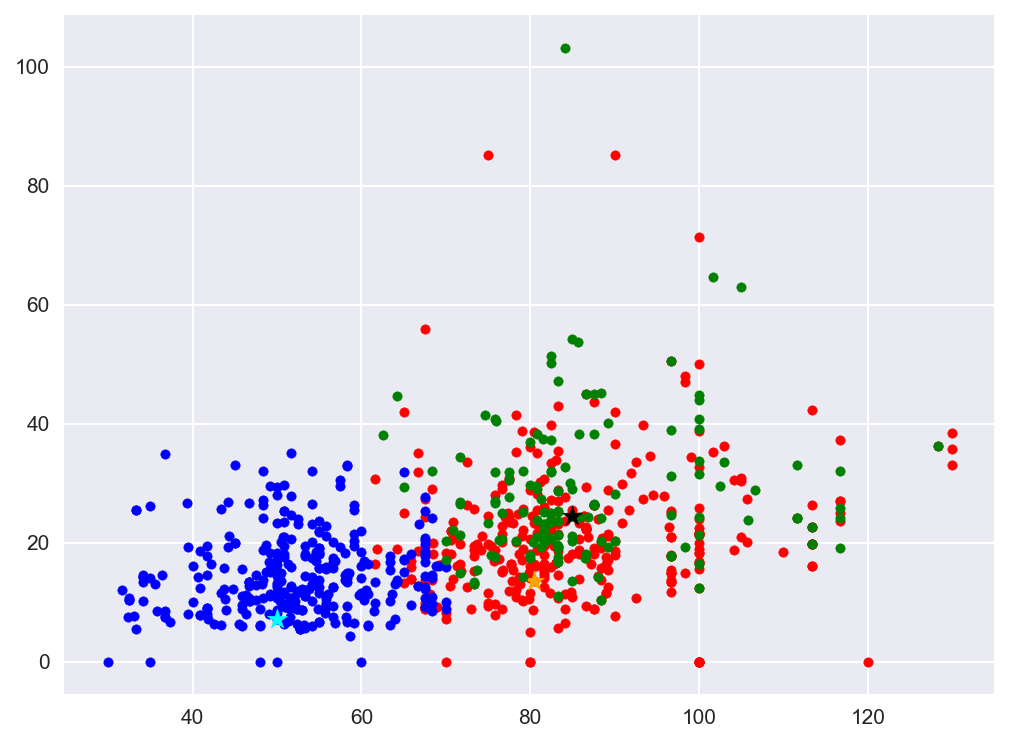

In [254]:
stat_df = Create_KCluster(list(stats.values),3)
plot_Cluster(stat_df.Center,stat_df.Points)

If we experiment with different values of K, we find that clustering pokemon by their stats is not an easy task, at least not with what we are currently using. So, let's try other ways of clustering the stats data.

## Principal Component Analysis

PCA is a dimensionality reduction technique that tries to explain the variance between different variables into a smaller variable. So it can turn for example 6 features into two features, denoting the variance between them into just two variables. First, let's standardize the stats.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

stats[features] = StandardScaler().fit_transform(stats)
stats.head()

C:\Users\juan9\Anaconda3Fix\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\juan9\Anaconda3Fix\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
#,,,,,,
1,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503
2,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015
3,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635
3,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635
4,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853


And now apply PCA.

In [12]:
stats_PCA = PCA().fit_transform(stats)
stats_PCA

array([[ -1.55637470e+00,  -2.14821179e-02,   6.66503916e-01,
          1.84176275e-01,  -4.03807164e-01,  -3.03004160e-01],
       [ -3.62866562e-01,  -5.02685402e-02,   6.67913494e-01,
          2.69254499e-01,  -2.25788390e-01,  -1.94486743e-01],
       [  1.28015158e+00,  -6.27202220e-02,   6.23913942e-01,
          3.31391357e-01,  -1.54529229e-03,  -6.81769707e-02],
       ..., 
       [  2.45821626e+00,  -5.15881585e-01,   1.11019708e+00,
          8.18385758e-01,  -1.19238529e+00,  -1.26181155e+00],
       [  3.53039710e+00,  -9.51065159e-01,   4.08283851e-01,
          1.80710181e-01,  -1.75283169e+00,  -1.82420367e+00],
       [  2.23378629e+00,   5.37629850e-01,   2.43320150e-01,
         -3.45706735e-01,  -1.06076727e+00,   4.30883742e-01]])

In [13]:
stats_PCA.shape

(800, 6)

Finally, let's apply clustering once more, this time using the sklearn library.

In [43]:
from sklearn.cluster import KMeans
num_clusters =4
kmeans_pca = KMeans(num_clusters).fit(stats_PCA)

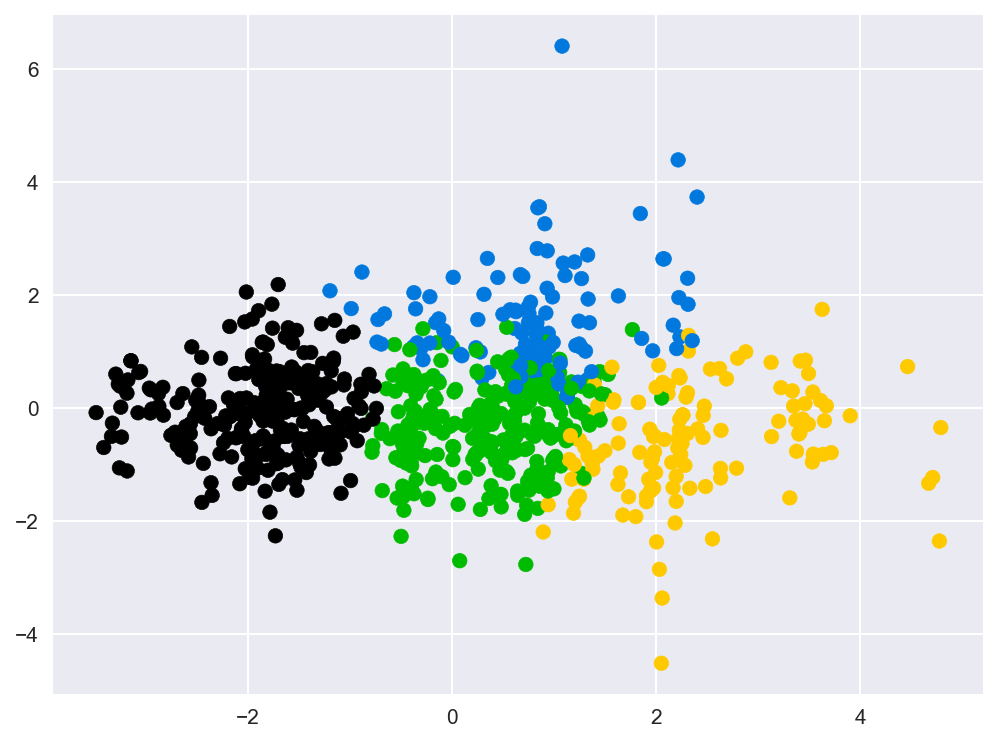

In [44]:
cmap = plt.get_cmap('nipy_spectral')
plt.scatter(stats_PCA[:,0], stats_PCA[:, 1], color = cmap(kmeans_pca.labels_/ num_clusters))
plt.show()

That's way nicer! However, what do all these clusters mean in the grand scheme of things? The whole point of clustering is to be able to label unlabeled data by things they have in common. So, to take a look at this, let's group the stats by their PCA cluster centers, and see what these stats represent.

In [35]:
stats['pca'] = kmeans_pca.labels_
df_stats_mean = stats.groupby('pca').mean()
df_stats_mean.head()

C:\Users\juan9\Anaconda3Fix\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
pca,,,,,,
0,0.704158,1.031597,0.506198,1.442508,0.938106,1.080386
1,-0.763352,-0.778916,-0.721118,-0.768840,-0.834694,-0.651547
2,0.004049,0.315692,1.531738,-0.095460,0.703414,-0.561366
3,0.420773,0.139938,-0.174617,0.099603,0.077930,0.360341


To visualize this in a clearer way, let's plot a correlation matrix using seaborn.

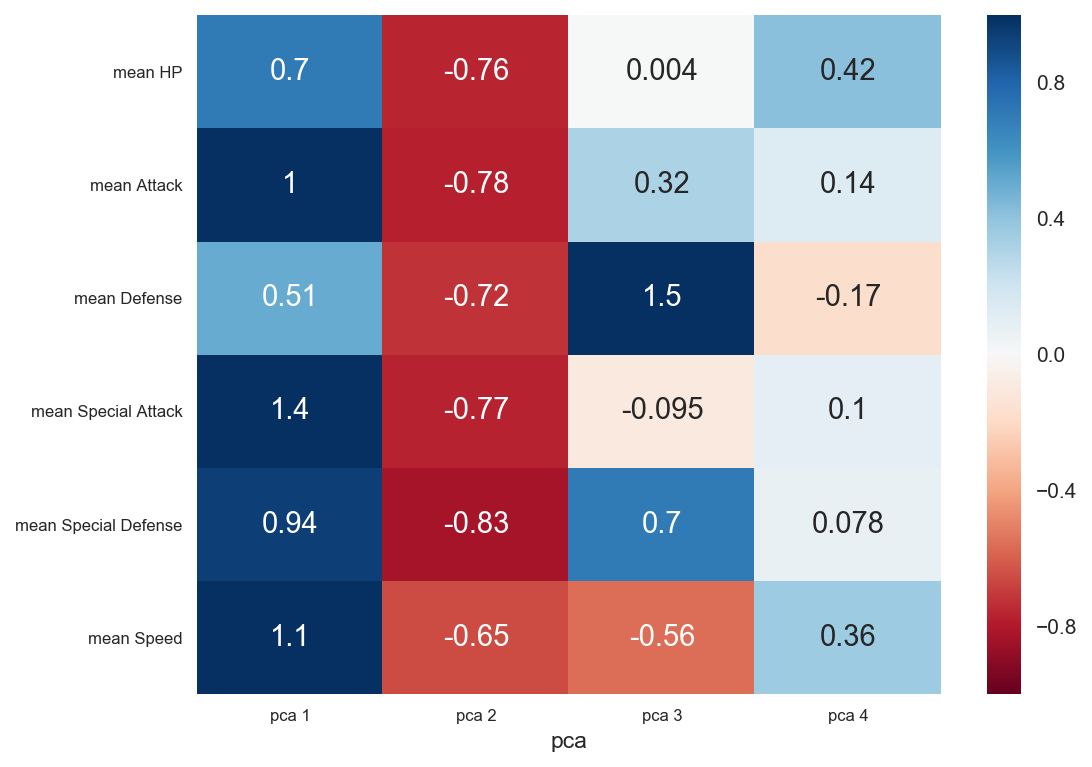

In [36]:

ax = sns.heatmap(df_stats_mean[features].transpose(), 
                 center=0, cmap="RdBu", vmin=-1, vmax=1, annot=True)
ax.set_xticklabels(['pca ' + str(i + 1) for i in range(num_clusters) ], rotation=0, fontsize=8);
ax.set_yticklabels(['mean HP', 'mean Attack', 'mean Defense', 'mean Special Attack',
                    'mean Special Defense','mean Speed'][::-1], rotation=0, fontsize=8);
plt.show()

So in the end, we were able to cluster pokemon by 3 groups based on their stats:

- label 0 or pca3: Defensive Pokemon with very high Defense, HP and Special Defense, but average attack, mediocre special attack and low speed.

- label 1 or pca1: Pokemon with low stats overall. 

- label 2 or pca2: Pokemon with high stats overall, but very high Special Attack, Speed and Attack. Offensive Pokemon.

Too see how many there were on each cluster, we can group the labels by counts. 

In [37]:
counts_df = pd.DataFrame(stats.groupby('pca').size().rename('counts'))
counts_df

,counts
pca,
0,136
1,276
2,116
3,272


So in the end, there are an almost equal number of offensive and defensive pokemon, but a huge amount of pokemon with low stats. This number may  be the non final evolutions of pokemon, which makes sense in this context. 

Try creating different sizes of clusters and see how they interact!

### References

This kaggle notebook: https://www.kaggle.com/vimary/tsne-vs-pca

This post: https://datasciencelab.wordpress.com/2013/12/12/clustering-with-k-means-in-python/